# Etude de l'impact de la crise sanitaire sur le nombre d'établissments en Grand Est sur chaque secteurs d'activité 

In [4]:
suppressPackageStartupMessages(require(skimr))
suppressPackageStartupMessages(require(readxl))
suppressPackageStartupMessages(require(stringr))
suppressPackageStartupMessages(require(dplyr))
suppressPackageStartupMessages(require(ggplot2))
suppressPackageStartupMessages(require(forecast))


In [5]:
#------------------------------------------------------
# data pre treatment (similar to univariate case)

df <- read_excel("data/data.xlsx",sheet = 3)
tmp <-df%>% filter(aire=="44_GRAND EST" & champ=="ESS")

df <-tmp[-which(!is.na(tmp$secret_stat)),]%>%select(-secret_stat)
df <- df %>% select(-champ,-type_aire,-type_naf,-aire)
df <- df[,c(TRUE,str_detect(colnames(df),"nb_etab")[-1])]
tmp <- t(df)
colnames(tmp) <- tmp[1,]
tmp <-tmp[-1,]
df <- tmp
tmp <-df%>%as.data.frame
tmp <-cbind("date"=rep(NA,nrow(tmp)),tmp)
for (i in 1:nrow(tmp)){
    tmp.format.date <- strsplit(rownames(df)[i],"nb_etab")[[1]][2]
    subsplit <-strsplit(tmp.format.date,"T")[[1]]
    year<-subsplit[1]
    trimester <- subsplit[2]
    month <-switch(trimester,
        "1"="01",
        "2"="04",
        "3"="07",
        "4"="10"
    )
    tmp[i,1] <- paste(year,month,"01",sep="-")
}
tmp$date <-as.Date(tmp$date)
rownames(tmp) <- NULL

df.indexes <-which(tmp$date < as.Date("2020-01-01"))
train.indexes<- which(tmp$date < as.Date("2018-01-01") )
test.indexes <-which(tmp$date>= as.Date("2018-01-01") & tmp$date <as.Date("2020-01-01") )
tmp <-tmp %>%select(-date)%>% mutate_all(as.numeric)
#----------------------------
# Eliminate total serie
tmp <- tmp[,-ncol(tmp)]
df.ts <- ts(tmp[df.indexes,],start=c(2010,1),frequency=4)# S'arrete à 2019 Q4
train.ts <-ts(tmp[train.indexes,],start=c(2010,1),frequency = 4)# S'arrete à 2017 Q4
test.ts <-ts(tmp[test.indexes,],start = c(2018,1),frequency = 4)# Commence a 2018 Q1 --> 2019 Q4
global.ts <- ts(tmp,start=c(2010,1),frequency=4)# Commence a 2010 Q1 --> 2021 Q2
covid.ts <- ts(tmp[(df.indexes[length(df.indexes)]+1):nrow(tmp),],start=c(2020,1),frequency = 4)# Commence a 2020 Q1 --> 2021 Q2 

In [6]:
suppressPackageStartupMessages(require(vars))

In [7]:
df.ts %>%head
cat("dim : ",dim(df.ts))

,"64 Activités des services financiers, hors assurance et",65-66 Assurance ; Activités auxiliaires de services fin,852 Enseignement primaire,853 Enseignement secondaire,85x Enseignement / Autre,861 Activités hospitalières,862 Activité des médecins et des dentistes,869 Autres activités pour la santé humaine,87 Hébergement médico-social et social,881 Action sociale sans hébergement pour personnes âgée,889 Autre action sociale sans hébergement,931 Activités liées au sport,932 Activités récréatives et de loisirs,FZ_Construction,"GZ_Commerce, réparation d'automobiles et de motocycles",HZ_Transports et entreposage,IZ_Hébergement et restauration,JA_Edition et audiovisuel,JB-JC_Télécommunications et ativités informatiques,LZ_Activités immobilières,"MA_Activités juridiques, de conseil et d'ingénierie",MB-MC_R&d et autres activités scientifiques et techniqu,NZ_Activités de services administratifs et de soutien,"RZ_Arts, spectacles et activités récréatives",SZ_autres activités de services,i_Industrie et agriculture
2010 Q1,1290,355,70,156,1183,94,135,123,898,573,1435,1431,209,45,306,17,261,109,18,32,211,67,338,978,3087,49
2010 Q2,1284,354,72,156,1192,92,136,124,897,570,1451,1445,213,42,302,17,263,112,19,30,212,69,341,1019,3154,50
2010 Q3,1279,356,72,156,1147,92,148,126,902,572,1462,1382,228,42,319,17,299,109,19,32,205,71,346,996,3119,54
2010 Q4,1278,347,72,156,1185,94,139,125,905,573,1435,1459,212,42,315,17,252,112,19,32,199,71,345,1023,3133,51
2011 Q1,1276,393,71,155,1168,99,150,124,902,565,1437,1438,209,43,307,17,254,111,20,29,198,71,341,1002,3056,49
2011 Q2,1274,394,71,153,1179,98,151,125,908,561,1439,1410,208,41,303,17,255,110,17,29,204,69,346,1035,3107,47


dim :  40 26

En multivarié on est en présence d'un processus de 26 dimensions de longueur $T=40$

In [8]:
#dimnames(df.ts)[2]
colnames(df.ts)

[1] "64 Activités des services financiers, hors assurance et"
 [2] "65-66 Assurance ; Activités auxiliaires de services fin"
 [3] "852 Enseignement primaire"                              
 [4] "853 Enseignement secondaire"                            
 [5] "85x Enseignement / Autre"                               
 [6] "861 Activités hospitalières"                            
 [7] "862 Activité des médecins et des dentistes"             
 [8] "869 Autres activités pour la santé humaine"             
 [9] "87 Hébergement médico-social et social"                 
[10] "881 Action sociale sans hébergement pour personnes âgée"
[11] "889 Autre action sociale sans hébergement"              
[12] "931 Activités liées au sport"                           
[13] "932 Activités récréatives et de loisirs"                
[14] "FZ_Construction"                                        
[15] "GZ_Commerce, réparation d'automobiles et de motocycles" 
[16] "HZ_Transports et entreposage"                           
[17] "IZ_Hébergement et restauration"                         
[18] "JA_Edition et audiovisuel"                              
[19] "JB-JC_Télécommunications et ativités informatiques"     
[20] "LZ_Activités immobilières"                              
[21] "MA_Activités juridiques, de conseil et d'ingénierie"    
[22] "MB-MC_R&d et autres activités scientifiques et techniqu"
[23] "NZ_Activités de services administratifs et de soutien"  
[24] "RZ_Arts, spectacles et activités récréatives"           
[25] "SZ_autres activités de services"                        
[26] "i_Industrie et agriculture"

**Dans un premier temps nous allons continuer notre démarche naîvement , en ne prenant pas compte le problème de dimension induit par un processus de 27 dimensions**

<hr>

## I. Statistiques descriptives de notre processus

In [9]:
mean(df.ts[,1])

[1] 1199.7

In [10]:
ts.means  <- apply(df.ts,2,mean)%>% as.data.frame()
names(ts.means) <- "mean"
ts.means


,mean
,<dbl>
"64 Activités des services financiers, hors assurance et",1199.700
65-66 Assurance ; Activités auxiliaires de services fin,387.325
852 Enseignement primaire,68.950
853 Enseignement secondaire,147.925
85x Enseignement / Autre,1145.850
861 Activités hospitalières,97.875
862 Activité des médecins et des dentistes,159.850
869 Autres activités pour la santé humaine,131.475
87 Hébergement médico-social et social,939.675


In [11]:
apply(df.ts,2,summary)

,"64 Activités des services financiers, hors assurance et",65-66 Assurance ; Activités auxiliaires de services fin,852 Enseignement primaire,853 Enseignement secondaire,85x Enseignement / Autre,861 Activités hospitalières,862 Activité des médecins et des dentistes,869 Autres activités pour la santé humaine,87 Hébergement médico-social et social,881 Action sociale sans hébergement pour personnes âgée,⋯,IZ_Hébergement et restauration,JA_Edition et audiovisuel,JB-JC_Télécommunications et ativités informatiques,LZ_Activités immobilières,"MA_Activités juridiques, de conseil et d'ingénierie",MB-MC_R&d et autres activités scientifiques et techniqu,NZ_Activités de services administratifs et de soutien,"RZ_Arts, spectacles et activités récréatives",SZ_autres activités de services,i_Industrie et agriculture
Min.,1063.00,347.000,66.00,144.000,1055.00,92.000,135.00,123.000,897.000,547.000,⋯,210.000,103.000,12.00,24.00,188.00,58.00,278.0,978.00,2870.00,47.00
1st Qu.,1147.25,381.000,68.00,145.000,1119.00,96.750,152.00,126.750,919.000,551.000,⋯,218.000,109.000,15.75,28.00,196.50,61.00,309.5,1000.75,3052.25,53.00
Median,1214.50,390.000,69.00,146.500,1161.50,98.000,158.50,132.500,942.000,552.000,⋯,230.500,111.500,17.00,30.50,198.50,65.00,325.0,1025.00,3104.00,55.00
Mean,1199.70,387.325,68.95,147.925,1145.85,97.875,159.85,131.475,939.675,554.475,⋯,235.825,111.375,16.75,30.35,198.55,65.35,319.6,1024.20,3072.20,55.85
3rd Qu.,1257.50,394.250,70.00,148.250,1179.75,99.000,173.00,135.250,955.250,555.000,⋯,247.500,113.000,18.25,32.00,202.00,69.00,335.0,1040.25,3134.75,58.00
Max.,1318.00,418.000,73.00,157.000,1206.00,101.000,181.00,141.000,986.000,573.000,⋯,299.000,121.000,20.00,35.00,212.00,75.00,350.0,1081.00,3168.00,69.00


 L'on va rename les label de chaque secteurs d'activité afin de garder les prochains graphes lisibles

In [12]:
colnames(df.ts) %>%length

[1] 26

In [13]:
print("CORRESPONDANCE LABEL - NOMBRE SECTEURS")
lab.to.num <-cbind("lab"=colnames(df.ts),"num"=1:length(colnames(df.ts))) %>%as.data.frame
lab.to.num$num <- as.numeric(lab.to.num$num)
lab.to.num

[1] "CORRESPONDANCE LABEL - NOMBRE SECTEURS"


lab,num
<chr>,<dbl>
"64 Activités des services financiers, hors assurance et",1
65-66 Assurance ; Activités auxiliaires de services fin,2
852 Enseignement primaire,3
853 Enseignement secondaire,4
85x Enseignement / Autre,5
861 Activités hospitalières,6
862 Activité des médecins et des dentistes,7
869 Autres activités pour la santé humaine,8
87 Hébergement médico-social et social,9


In [14]:
colnames(df.ts) <-lab.to.num$num

Loading required package: corrplot

corrplot 0.92 loaded



lab,num
<chr>,<dbl>
"64 Activités des services financiers, hors assurance et",1
65-66 Assurance ; Activités auxiliaires de services fin,2
852 Enseignement primaire,3
853 Enseignement secondaire,4
85x Enseignement / Autre,5
861 Activités hospitalières,6
862 Activité des médecins et des dentistes,7
869 Autres activités pour la santé humaine,8
87 Hébergement médico-social et social,9


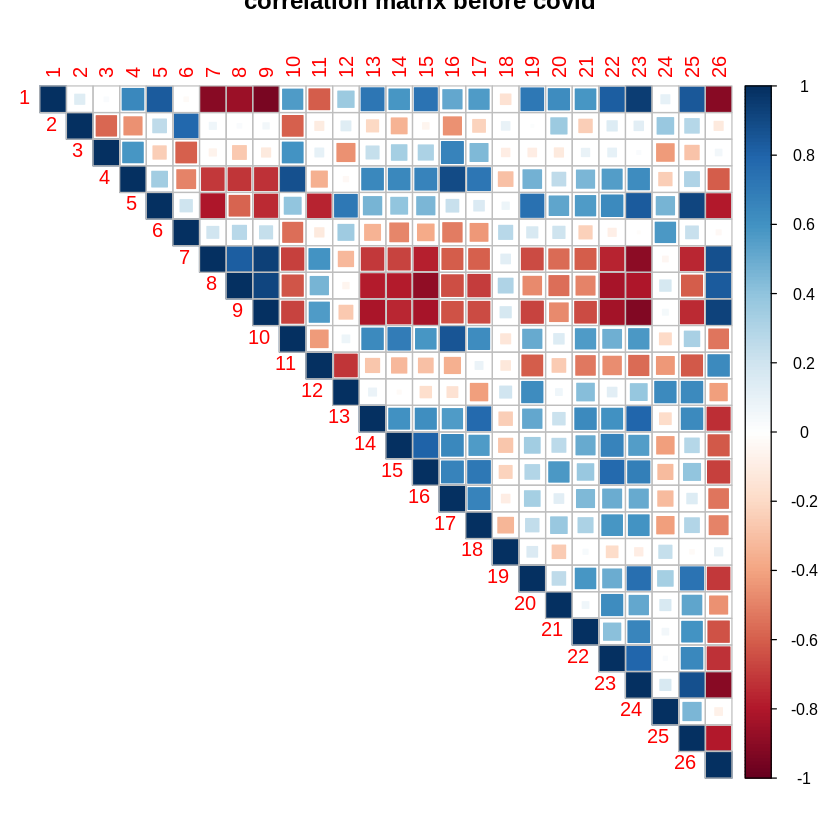

In [15]:
require(corrplot)
mcor <- cor(df.ts)
corrplot(mcor,method="square",type = "upper", title="correlation matrix before covid")
lab.to.num

On peux voir qu'il y a des correlations plutot importantes entre nos différents secteurs d'activités.

Ceci montre qu'une analyse en multivarié à un interets. **En effets, étudier ces processus en multivariés permet de prendre en considerations les liens entre chaqun de ses processus afin de batir de meilleures prédiction qu'en univarié**

Regardons par la même occasion les statistiques lors de la période covid.

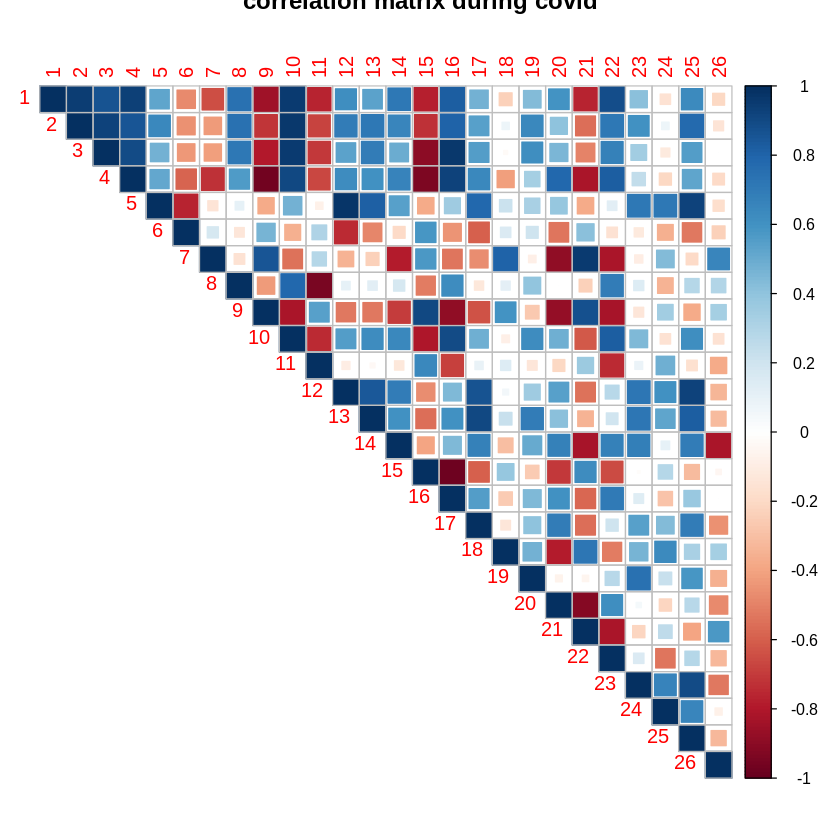

In [16]:
colnames(covid.ts) <- lab.to.num$num
mcor.covid <- cor(covid.ts)
corrplot(mcor.covid,method="square",type = "upper",title="correlation matrix during covid")

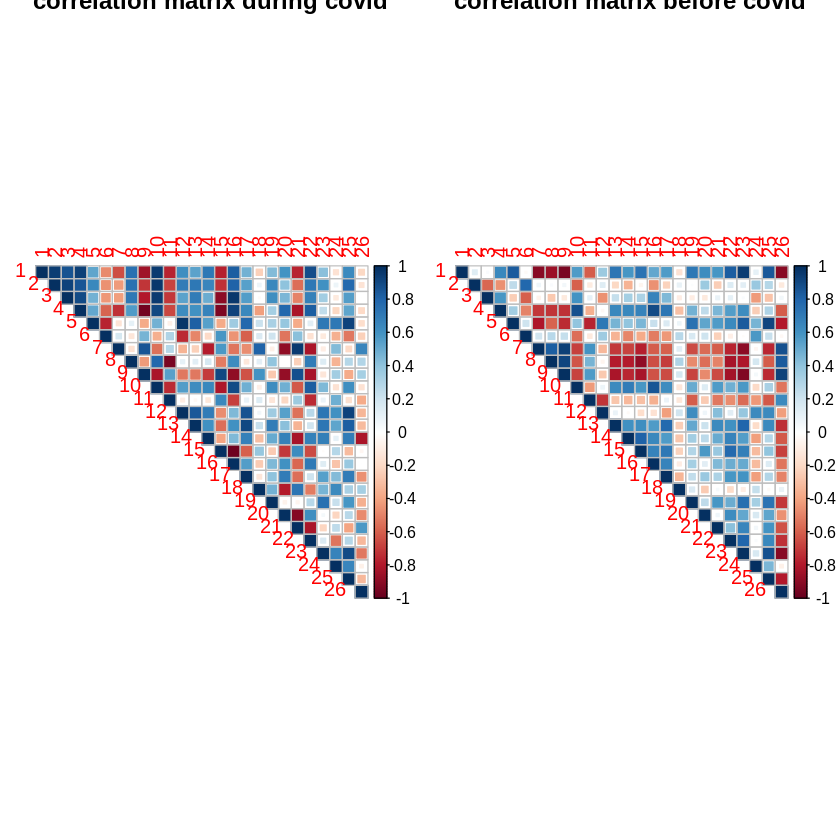

In [17]:
par(mfrow=c(1,2),mar=c(5,4,4,2))
corrplot(mcor.covid,method="square",type = "upper",title="correlation matrix during covid")
corrplot(mcor,method="square",type = "upper", title="correlation matrix before covid")

 <hr>

## II.B. Multivariate TS Analysis

In [18]:
test <-ur.df(df.ts[,1],type="none")
#summary(test)
print("Critical value ---------------")
cval <-attr(test,"cval")
cval

cval <-cval[1,3]
print(" Stat Test -----------------")
T_stat <- attr(test,"teststat")
T_stat
T_stat <- T_stat[1,1]
# Si test stat > Cval on n peux rejeter Ho : Présence d'unit root 
# Sinon on puex rejeter Ho : Stationnarité



# Dans notre cas : test Val > critical valuess : On peux rejeter l'hypothese d'une racine unitaire
if(T_stat >cval){
    print("Présence d'unit root")
}

[1] "Critical value ---------------"


,1pct,5pct,10pct
tau1,-2.62,-1.95,-1.61


[1] " Stat Test -----------------"


,tau1
statistic,-2.254974


In [19]:
alpha <- 0.1
stationary.list.1 <- list(
    "stable" = c(),
    "non-stable"=c()
)
stationary.list.2 <- list(
    "stable" = c(),
    "non-stable"=c()
)
stationary.list.3 <- list(
    "stable" = c(),
    "non-stable"=c()
)


for (index in 1: dim(df.ts)[2]){
    i <- df.ts[,index]
    test.1 <-ur.df(i,type="none")
    test.2 <-ur.df(i,type="drift")
    test.3 <-ur.df(i,type="trend")
    cval.1 <-attr(test.1,"cval")
    cval.2 <-attr(test.2,"cval")
    cval.3 <-attr(test.3,"cval")
    cval.1 <-cval.1[1,3]
    cval.2 <-cval.2[1,3]
    cval.3 <-cval.3[1,3]


    T_stat.1 <- attr(test.1,"teststat")
    T_stat.2 <- attr(test.2,"teststat")
    T_stat.3 <- attr(test.3,"teststat")
    T_stat.1 <- T_stat.1[1,1]
    T_stat.2 <- T_stat.2[1,1]
    T_stat.3 <- T_stat.3[1,1]

    bool.1<-T_stat.1 < cval.1
    bool.2<-T_stat.2 < cval.2
    bool.3<-T_stat.3 < cval.3
    
    if (bool.1){
        stationary.list.1[["stable"]]<- c(stationary.list.1[["stable"]],colnames(df.ts)[index])
    }else{
        stationary.list.1[["non-stable"]]<- c(stationary.list.1[["non-stable"]],colnames(df.ts)[index])    
    }
    if (bool.2){
        stationary.list.2[["stable"]]<- c(stationary.list.2[["stable"]],colnames(df.ts)[index])
    }else{
        stationary.list.2[["non-stable"]]<- c(stationary.list.2[["non-stable"]],colnames(df.ts)[index])    
    }

    if (bool.3){
        stationary.list.3[["stable"]]<- c(stationary.list.3[["stable"]],colnames(df.ts)[index])
    }else{
        stationary.list.3[["non-stable"]]<- c(stationary.list.3[["non-stable"]],colnames(df.ts)[index])    
    }
    
}



In [20]:
stationary.list.1
stationary.list.2
stationary.list.3

$stable
[1] "1"  "23" "25"

$`non-stable`
 [1] "2"  "3"  "4"  "5"  "6"  "7"  "8"  "9"  "10" "11" "12" "13" "14" "15" "16"
[16] "17" "18" "19" "20" "21" "22" "24" "26"

$stable
[1] "6"  "10" "17" "18" "21"

$`non-stable`
 [1] "1"  "2"  "3"  "4"  "5"  "7"  "8"  "9"  "11" "12" "13" "14" "15" "16" "19"
[16] "20" "22" "23" "24" "25" "26"

$stable
[1] "7"  "17" "18" "21" "22"

$`non-stable`
 [1] "1"  "2"  "3"  "4"  "5"  "6"  "8"  "9"  "10" "11" "12" "13" "14" "15" "16"
[16] "19" "20" "23" "24" "25" "26"

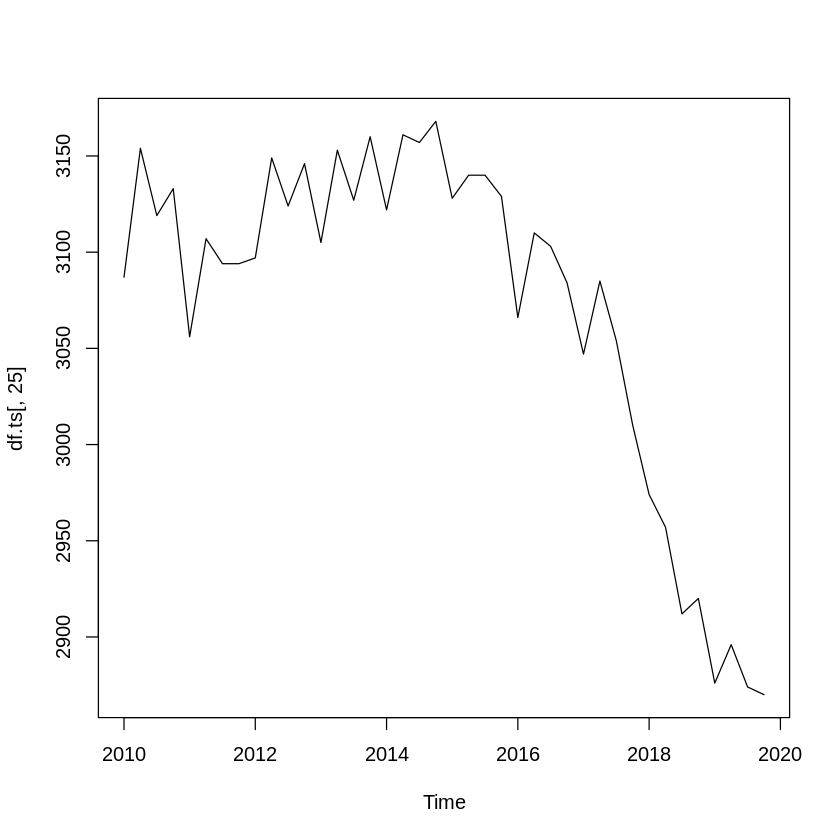

In [21]:
plot.ts(df.ts[,25])

Aucun n'est stationnaire

In [22]:
diff.df.ts <-diff(df.ts)

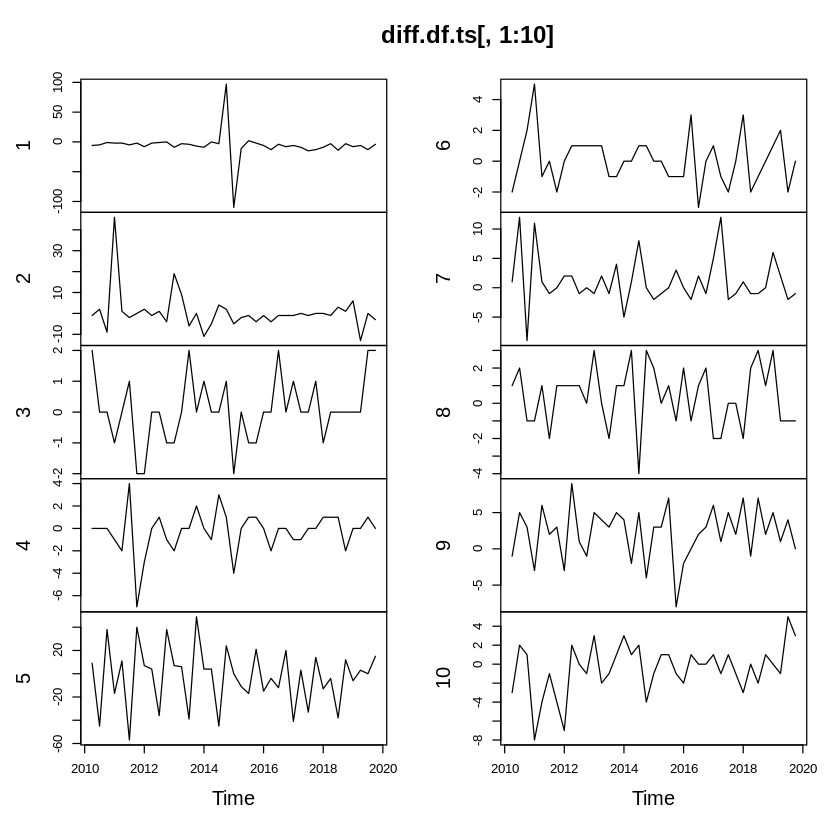

In [23]:
plot.ts(diff.df.ts[,1:10])

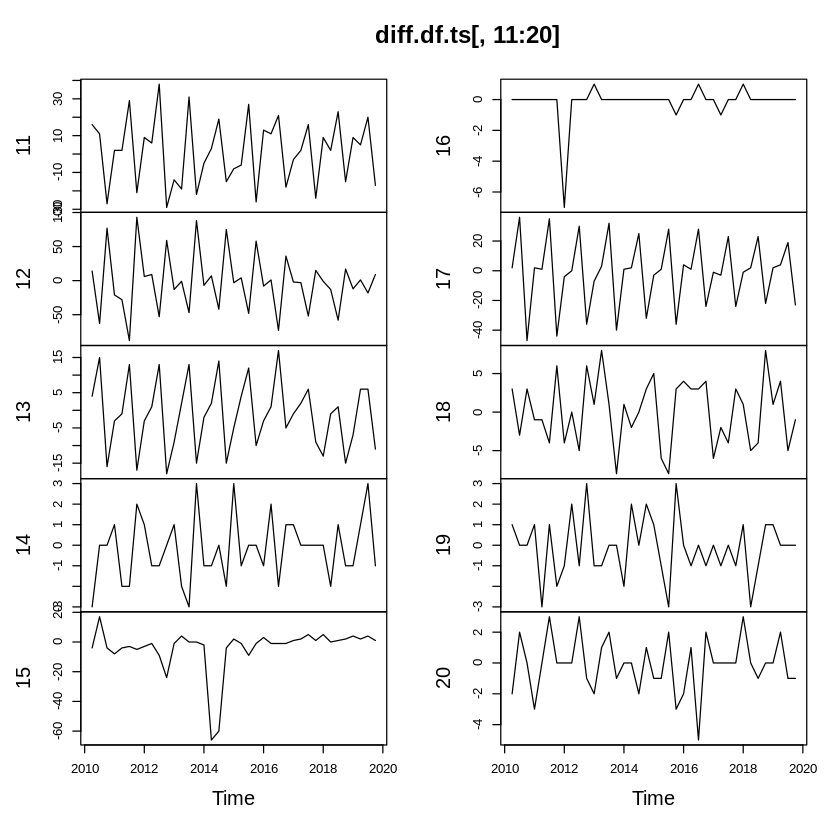

In [24]:
plot.ts(diff.df.ts[,11:20])

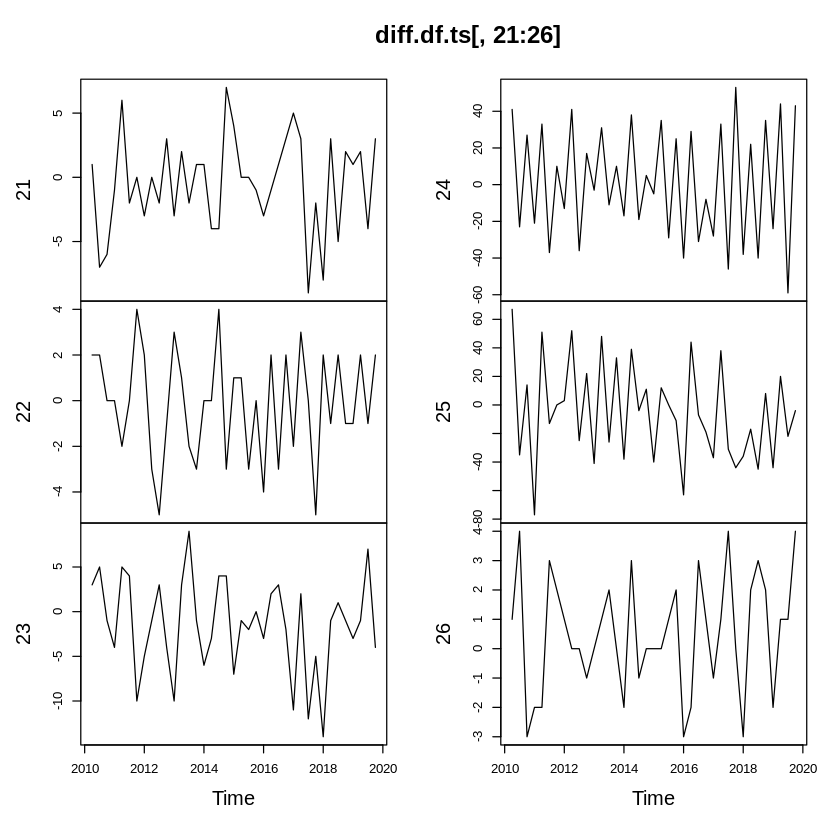

In [25]:
plot.ts(diff.df.ts[,21:26])

In [26]:
alpha <- 0.1
stationary.list.1 <- list(
    "stable" = c(),
    "non-stable"=c()
)
stationary.list.2 <- list(
    "stable" = c(),
    "non-stable"=c()
)
stationary.list.3 <- list(
    "stable" = c(),
    "non-stable"=c()
)


for (index in 1: dim(df.ts)[2]){
    i <- diff.df.ts[,index]
    test.1 <-ur.df(i,type="none")
    test.2 <-ur.df(i,type="drift")
    test.3 <-ur.df(i,type="trend")
    cval.1 <-attr(test.1,"cval")
    cval.2 <-attr(test.2,"cval")
    cval.3 <-attr(test.3,"cval")
    cval.1 <-cval.1[1,3]
    cval.2 <-cval.2[1,3]
    cval.3 <-cval.3[1,3]


    T_stat.1 <- attr(test.1,"teststat")
    T_stat.2 <- attr(test.2,"teststat")
    T_stat.3 <- attr(test.3,"teststat")
    T_stat.1 <- T_stat.1[1,1]
    T_stat.2 <- T_stat.2[1,1]
    T_stat.3 <- T_stat.3[1,1]

    bool.1<-T_stat.1 < cval.1
    bool.2<-T_stat.2 < cval.2
    bool.3<-T_stat.3 < cval.3
    
    if (bool.1){
        stationary.list.1[["stable"]]<- c(stationary.list.1[["stable"]],colnames(df.ts)[index])
    }else{
        stationary.list.1[["non-stable"]]<- c(stationary.list.1[["non-stable"]],colnames(df.ts)[index])    
    }
    if (bool.2){
        stationary.list.2[["stable"]]<- c(stationary.list.2[["stable"]],colnames(df.ts)[index])
    }else{
        stationary.list.2[["non-stable"]]<- c(stationary.list.2[["non-stable"]],colnames(df.ts)[index])    
    }

    if (bool.3){
        stationary.list.3[["stable"]]<- c(stationary.list.3[["stable"]],colnames(df.ts)[index])
    }else{
        stationary.list.3[["non-stable"]]<- c(stationary.list.3[["non-stable"]],colnames(diff.df.ts)[index])    
    }
    
}


In [27]:
stationary.list.1
stationary.list.2
stationary.list.3

$stable
 [1] "1"  "2"  "3"  "4"  "5"  "6"  "7"  "8"  "9"  "10" "11" "12" "13" "14" "15"
[16] "16" "17" "18" "19" "20" "21" "22" "23" "24" "25" "26"

$`non-stable`
NULL

$stable
 [1] "1"  "2"  "3"  "4"  "5"  "6"  "7"  "8"  "9"  "10" "11" "12" "13" "14" "15"
[16] "16" "17" "18" "19" "20" "21" "22" "23" "24" "25" "26"

$`non-stable`
NULL

$stable
 [1] "1"  "2"  "3"  "4"  "5"  "6"  "7"  "8"  "9"  "10" "11" "12" "13" "14" "15"
[16] "16" "17" "18" "19" "20" "21" "22" "23" "24" "25" "26"

$`non-stable`
NULL

Utilisation de la differenciation du premeir ordre pour les compasants non stationnaire. Cette differnciation semble avoir permier de stationnarisé l'ensemble des processus

 <hr>

## Trying to detect co integration


In [52]:
p=5
mod.tmp <- vars::VAR(diff.df.ts,p,type="const",ic=c("AIC","SC","FPE"))
summary(mod.tmp)


Warning message in cor(resids):
“the standard deviation is zero”


ERROR: Error in solve.default(Sigma): Lapack routine dgesv: system is exactly singular: U[1,1] = 0


Error message : cor(resid) is zeros

In [53]:
residuals(mod.tmp)# DIM 34 *26
sum(residuals(mod.tmp)==0)==34*26

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,⋯,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26
1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


[1] TRUE

All residuals are zeros

In [50]:
Ps <- 1:10
p=2
mod.tmp <- vars::VAR(diff.df.ts[,1:5],p,type="const",ic=c("AIC","SC","FPE"))
summary(mod.tmp)



VAR Estimation Results:
Endogenous variables: X1, X2, X3, X4, X5 
Deterministic variables: const 
Sample size: 37 
Log Likelihood: -558.205 
Roots of the characteristic polynomial:
0.7641 0.6433 0.6433 0.5983 0.5237 0.5237 0.2419 0.2419 0.1811 0.1811
Call:
vars::VAR(y = diff.df.ts[, 1:5], p = p, type = "const", ic = c("AIC", 
    "SC", "FPE"))


Estimation results for equation X1: 
X1 = X1.l1 + X2.l1 + X3.l1 + X4.l1 + X5.l1 + X1.l2 + X2.l2 + X3.l2 + X4.l2 + X5.l2 + const 

        Estimate Std. Error t value Pr(>|t|)  
X1.l1  -0.557811   0.210932  -2.645   0.0137 *
X2.l1   0.198268   0.463383   0.428   0.6723  
X3.l1  -5.104691   4.934589  -1.034   0.3104  
X4.l1   3.608275   2.610440   1.382   0.1787  
X5.l1  -0.203679   0.198228  -1.027   0.3137  
X1.l2  -0.243990   0.204974  -1.190   0.2447  
X2.l2  -0.007818   0.449952  -0.017   0.9863  
X3.l2   0.574138   4.971111   0.115   0.9089  
X4.l2  -1.104398   2.670269  -0.414   0.6826  
X5.l2  -0.066251   0.217834  -0.304   0.7634  
cons

In [51]:
serial.test(mod.tmp,type="PT.asymptotic")
serial.test(mod.tmp,type="PT.adjusted")



	Portmanteau Test (asymptotic)

data:  Residuals of VAR object mod.tmp
Chi-squared = 290.66, df = 350, p-value = 0.9908

$serial

	Portmanteau Test (asymptotic)

data:  Residuals of VAR object mod.tmp
Chi-squared = 290.66, df = 350, p-value = 0.9908




	Portmanteau Test (adjusted)

data:  Residuals of VAR object mod.tmp
Chi-squared = 389.58, df = 350, p-value = 0.07104

$serial

	Portmanteau Test (adjusted)

data:  Residuals of VAR object mod.tmp
Chi-squared = 389.58, df = 350, p-value = 0.07104



<hr>

In [126]:
mod.select <-VARselect(diff.df.ts[,1:4],type="both")
mod.select

Warning message in log(sigma.det):
“NaNs produced”
Warning message in log(sigma.det):
“NaNs produced”
Warning message in log(sigma.det):
“NaNs produced”


,1,2,3,4,5,6,7,8,9,10
AIC(n),10.47171,10.97582,11.11209,11.17030,10.40996,NaN,-Inf,-Inf,-Inf,-Inf
HQ(n),10.82610,11.56646,11.93899,12.23347,11.70939,NaN,-Inf,-Inf,-Inf,-Inf
SC(n),11.60327,12.86174,13.75238,14.56497,14.55900,NaN,-Inf,-Inf,-Inf,-Inf
FPE(n),36168.90868,65754.67855,95093.66173,165015.14205,216351.40591,-1.737984e-13,0,0,0,0


In [139]:
mod <-VAR(diff.df.ts[,1:3], p=8,type="const")
mod


VAR Estimation Results:

Estimated coefficients for equation X1: 
Call:
X1 = X1.l1 + X2.l1 + X3.l1 + X1.l2 + X2.l2 + X3.l2 + X1.l3 + X2.l3 + X3.l3 + X1.l4 + X2.l4 + X3.l4 + X1.l5 + X2.l5 + X3.l5 + X1.l6 + X2.l6 + X3.l6 + X1.l7 + X2.l7 + X3.l7 + X1.l8 + X2.l8 + X3.l8 + const 

       X1.l1        X2.l1        X3.l1        X1.l2        X2.l2        X3.l2 
 -0.96318520   0.69977321  -2.53326362  -0.65934941  -0.68147337  -9.28183444 
       X1.l3        X2.l3        X3.l3        X1.l4        X2.l4        X3.l4 
 -0.59344224  -1.27942812   6.39979926  -0.26263210   0.77805115  -1.96859278 
       X1.l5        X2.l5        X3.l5        X1.l6        X2.l6        X3.l6 
 -0.21136250   0.05712363   4.22956658  -0.19254326   0.72240661  -1.42027870 
       X1.l7        X2.l7        X3.l7        X1.l8        X2.l8        X3.l8 
 -0.13307396   0.83025025  -6.92491336  -0.03306036   0.18461460 -10.09695005 
       const 
-27.24568380 


Estimated coefficients for equation X2: 
Call:
X2 = X1.l1 + 

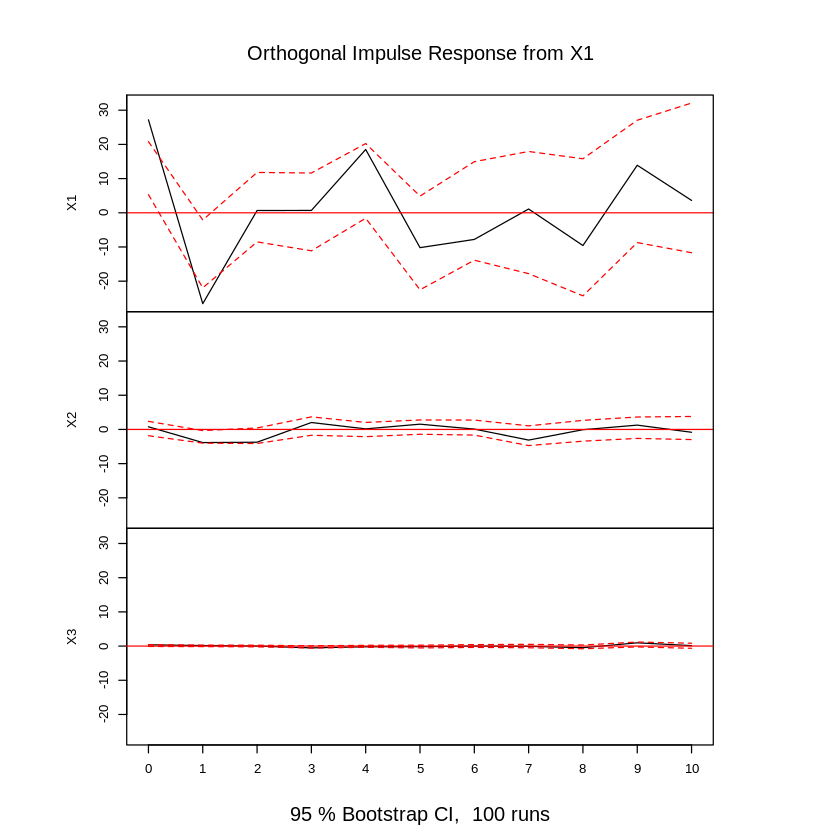

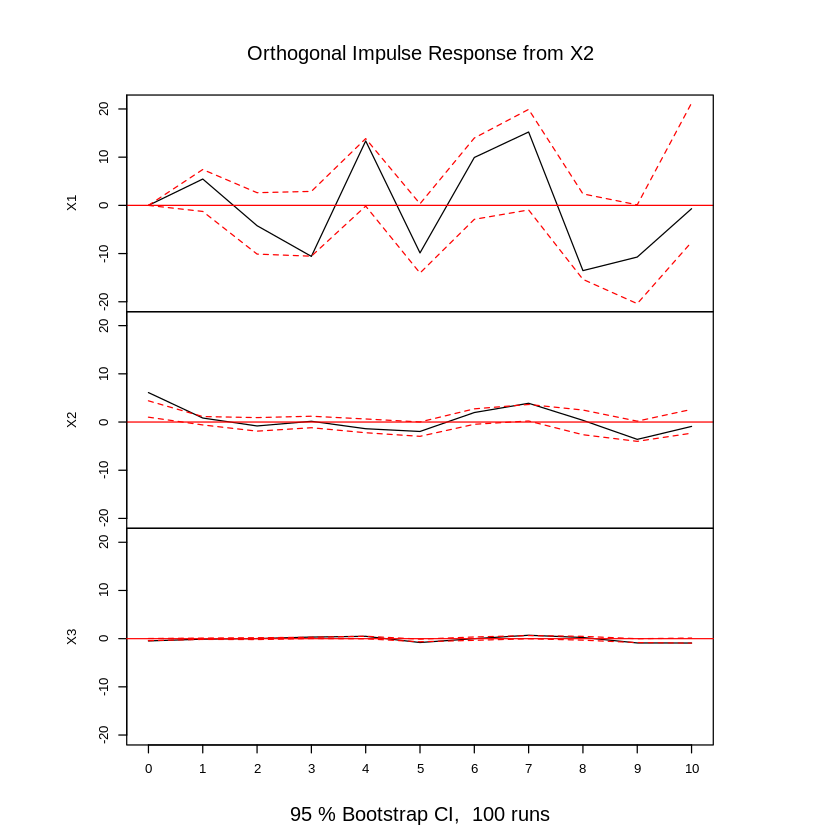

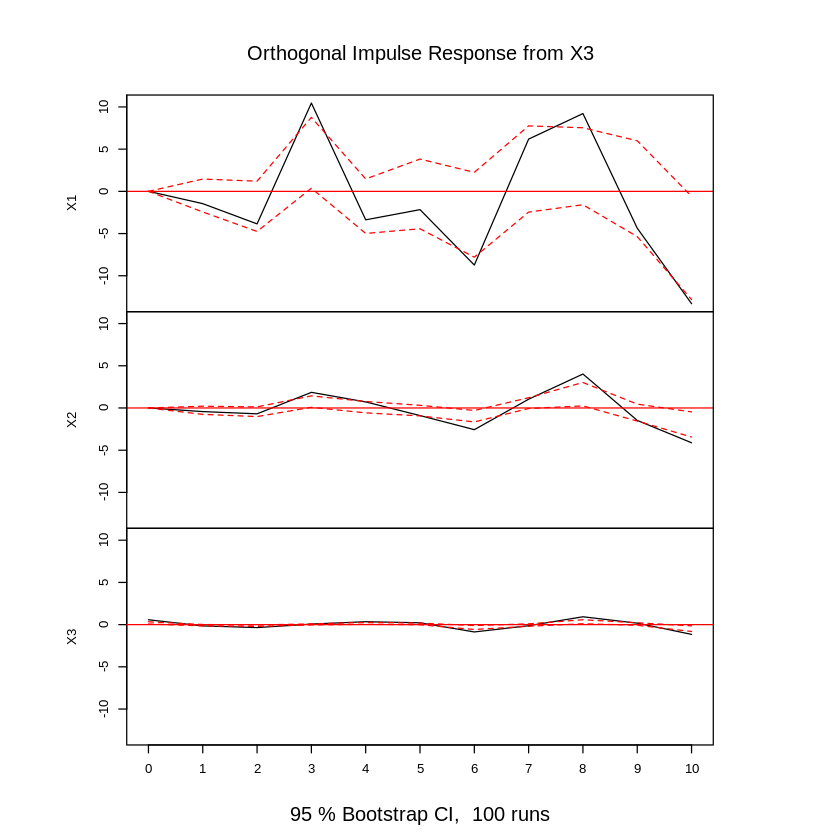

In [140]:
plot(irf(mod))